In [1]:
#Imports
import sys
sys.path.append("../")
import numpy
import os
import matplotlib
from classes import ModelWrapper, DataLoader, Cluster, Plotting

#Interactive matplotlib plots
%matplotlib widget

2024-03-08 13:36:20.744107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Initialisation
modelAPI = ModelWrapper.loadPostprocessed("../models/3D/base", "base")
track_type = "alltracks"
data_loader = DataLoader("../data")
noisy = data_loader.getBatch(True, True, track_type=track_type, normalising=True)
noisy_with_E = data_loader.getBatch(True, True, track_type=track_type, normalising=False)
clean = data_loader.getBatch(True,False, track_type=track_type)
classified = modelAPI.classify( modelAPI.evaluateBatch(noisy) )
names = data_loader.getX17Names(track_type)

2024-03-08 13:36:25.393077: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


21/21 [==============================] - 5s 209ms/step


In [3]:
#Find all and good clusters numbers
NN_all = 0
NN_good = 0
nonNN_all = 0
nonNN_good = 0

for i in range(classified.shape[0]):
	for cluster in Cluster.clusterise(clean[i]):
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	nonNN_good += 1
		nonNN_all += 1

	for cluster in Cluster.clusterise(classified[i]):
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	NN_good += 1
		NN_all += 1

print("# nonNN clusters:", nonNN_all)
print("# nonNN good clusters:", nonNN_good)
print("# NN clusters:", NN_all)
print("# NN good clusters:", NN_good)
print("")
print("nonNN relative precision:", nonNN_good / nonNN_all)
print("NN relative precision:", NN_good / NN_all)

# nonNN clusters: 815
# nonNN good clusters: 377
# NN clusters: 572
# NN good clusters: 291

nonNN relative precision: 0.4625766871165644
NN relative precision: 0.5087412587412588


In [4]:
#Fragmentation analysis
NN_all = 0
NN_good = []
nonNN_all = 0
nonNN_good = []
NN_fragmentation_number = 0
nonNN_fragmentation_number = 0

for i in range(classified.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)
	
	NN_fragmentation_number += len(clusters_NN) - len(clusters_NN_defrag)
	nonNN_fragmentation_number += len(clusters_nonNN) - len(clusters_nonNN_defrag)

	for cluster in clusters_nonNN_defrag:
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	nonNN_good.append(i)
		nonNN_all += 1

	for cluster in clusters_NN_defrag:
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	NN_good.append(i)
		NN_all += 1

print("# nonNN clusters after defragmentation:", nonNN_all)
print("# nonNN good clusters after defragmentation:", len(nonNN_good))
print("# NN clusters after defragmentation:", NN_all)
print("# NN good clusters after defragmentation:", len(NN_good))
print("")
print("nonNN relative precision:", len(nonNN_good) / nonNN_all)
print("NN relative precision:", len(NN_good) / NN_all)
print("")
print("nonNN fragmentation number:", nonNN_fragmentation_number)
print("NN fragmentation number:", NN_fragmentation_number)

# nonNN clusters after defragmentation: 699
# nonNN good clusters after defragmentation: 337
# NN clusters after defragmentation: 559
# NN good clusters after defragmentation: 290

nonNN relative precision: 0.4821173104434907
NN relative precision: 0.518783542039356

nonNN fragmentation number: 116
NN fragmentation number: 13


NN bad nonNN good: 36
NN good nonNN bad: 23
L: 52 , N_coef: 4.269230769230769 , tests: {'length': True, 'zone': True, 'neighbours': False, 'energy_density': True}
L: 1 , N_coef: 1.0 , tests: {'length': False, 'zone': True, 'neighbours': True, 'energy_density': True}
L: 1 , N_coef: 1.0 , tests: {'length': False, 'zone': True, 'neighbours': True, 'energy_density': True}


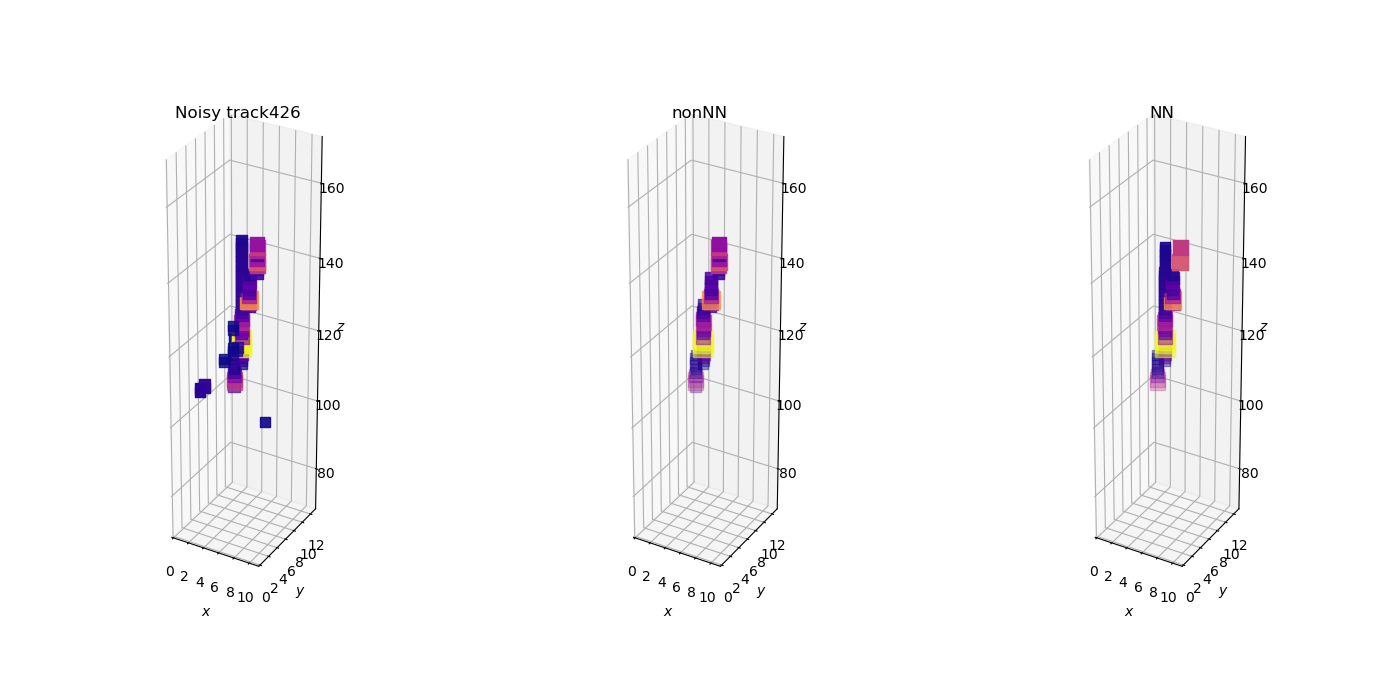

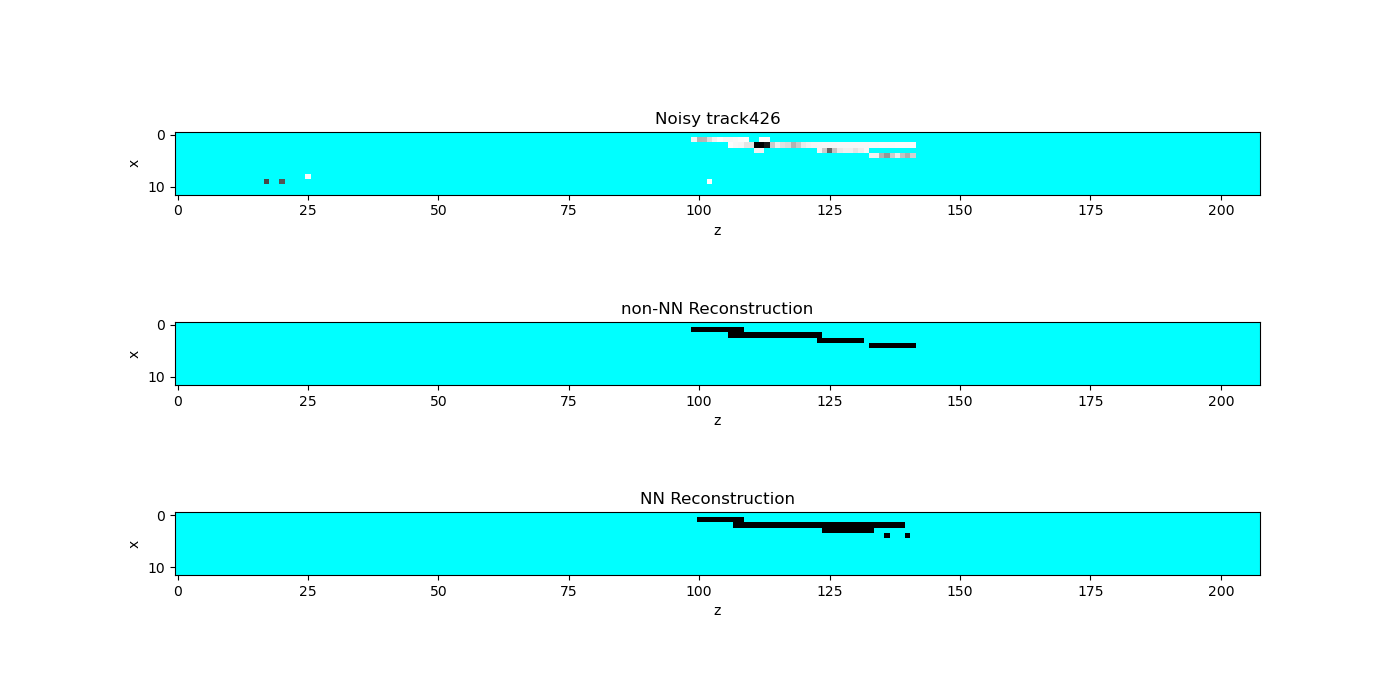

In [5]:
#Show good nonNN bad NN
diff = [i for i in nonNN_good if i not in NN_good]
other_diff = [i for i in NN_good if i not in nonNN_good]
index = numpy.random.choice(diff)
print("NN bad nonNN good:",len(diff))
print("NN good nonNN bad:", len(other_diff))

for cluster in Cluster.clusterise(classified[index]):
	cluster.setEnergy(noisy_with_E[index])
	cluster.runTests()
	print("L:", cluster.length, ", N_coef:", cluster.neighbour_coef, ", tests:", cluster.tests)

fig = matplotlib.pyplot.figure(figsize=matplotlib.pyplot.figaspect(0.33))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
Plotting.plot3DToAxis(noisy[index], ax1, "Noisy " + names[index], z_cut = (70,170))
Plotting.plot3DToAxis(clean[index], ax2, "nonNN", z_cut = (70,170))
E_max = numpy.max(noisy_with_E[index])

Plotting.plot3DToAxis(numpy.where(classified[index]>0, noisy[index],0), ax3, "NN", z_cut = (70,170))

fig.set_size_inches(14, 7)
fig.tight_layout()

Plotting.getPlotEventOneAxis(noisy[index], numpy.where(clean[index]>0,1,0), classified[index], 1, names[index])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(14, 7)


In [6]:
#Show fragmented
def areDuplicities(xs):
	duplicity_dict = {}
	for x in xs:
		if x in duplicity_dict:	return True
		duplicity_dict[x] = True
	return False

duplicities = []
for i in range(classified.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	connections1, connections2 = Cluster.crossconnectClusters(clusters_nonNN, clusters_NN)
	if areDuplicities(connections1):	duplicities.append((i,False))
	if areDuplicities(connections2):	duplicities.append((i,True))

nonNN Fragmented


[]

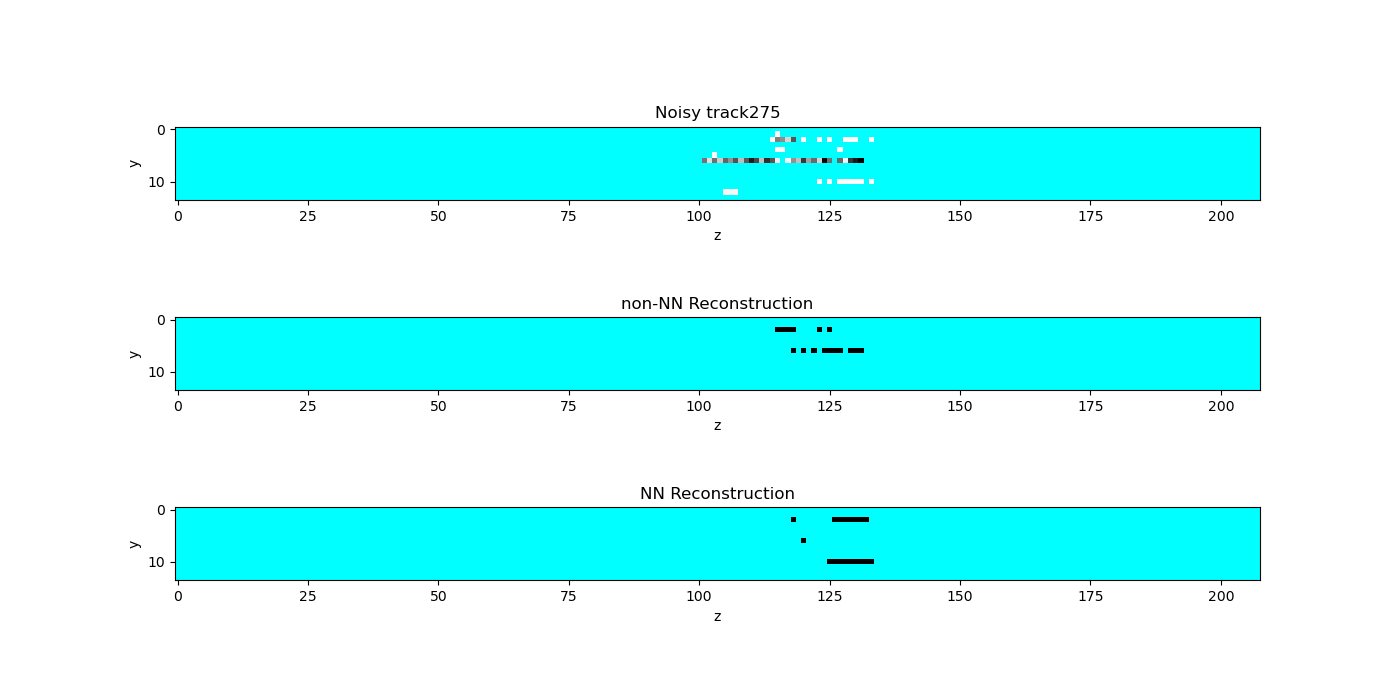

In [7]:
axis = 0

index, is_NN = numpy.random.default_rng().choice(duplicities)
if is_NN:	print("NN Fragmented")
else:	print("nonNN Fragmented")
Plotting.getPlotEventOneAxis(noisy[index], numpy.where(clean[index]>0,1,0), classified[index], axis, names[index])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(14, 7)
matplotlib.pyplot.plot()

In [8]:
#Compare all models numbers
#Find all and good clusters numbers
good_c = 0
all_c = 0

for i in range(clean.shape[0]):
	for cluster in Cluster.clusterise(clean[i]):
		cluster.setEnergy(noisy_with_E[i])
		cluster.runTests()
		if cluster.isGood():	good_c += 1
		all_c += 1

print("------------------")
print("nonNN all:", all_c)
print("nonNN relative precision:", good_c / all_c)
print("------------------")

for name in os.listdir("../models/3D/"):
	modelAPI = ModelWrapper.loadPostprocessed("../models/3D/" + name, name)
	temp_classified = modelAPI.classify( modelAPI.evaluateBatch(noisy) )
	
	good_c = 0
	all_c = 0
	for i in range(temp_classified.shape[0]):
		for cluster in Cluster.clusterise(temp_classified[i]):
			cluster.setEnergy(noisy_with_E[i])
			cluster.runTests()
			if cluster.isGood():	good_c += 1
			all_c += 1
	print(name + " all:", all_c, "relative precision:", good_c / all_c)

------------------
nonNN all: 815
nonNN relative precision: 0.4625766871165644
------------------
21/21 [==============================] - 5s 198ms/step
paralel3 all: 619 relative precision: 0.43618739903069464
21/21 [==============================] - 3s 145ms/step
mainlyLatent all: 670 relative precision: 0.4462686567164179
21/21 [==============================] - 4s 181ms/step
TPC_denoiser all: 671 relative precision: 0.46646795827123694
21/21 [==============================] - 4s 199ms/step
conv1x1x1 all: 1377 relative precision: 0.12490922294843863
21/21 [==============================] - 4s 189ms/step
baseSpatialDropout all: 661 relative precision: 0.4659606656580938
21/21 [==============================] - 6s 292ms/step
xyz_conv all: 681 relative precision: 0.5007342143906021
21/21 [==============================] - 3s 153ms/step
longTrain_lowCap all: 789 relative precision: 0.3929024081115336
21/21 [==============================] - 5s 212ms/step
with_stride all: 734 relative pr

In [9]:
#Numbers for set plot - clusters
counter = 0
for event in noisy:
	counter += len(Cluster.clusterise((event)))
print("All clusters:", counter)

table = {
	"NN":	{
		"fragmented":	{
			"all": 0,
			"good": []	},
		"defragmented":	{
			"all":	0,
			"good":	[]	},
		},
	"nonNN":	{
		"fragmented":	{
			"all": 0,
			"good": []	},
		"defragmented":	{
			"all":	0,
			"good":	[]	},
		}
	}

lone = {
	"NN":	{
		"all": 0,
		"good": 0
	},
	"nonNN":	{
		"all": 0,
		"good": 0
	}
}

def evaluate(cluster, E_event):
	cluster.setEnergy(E_event)
	cluster.runTests()
	return cluster.isGood()

for i in range(clean.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)

	table["NN"]["fragmented"]["all"] += len(clusters_NN)
	table["NN"]["defragmented"]["all"] += len(clusters_NN_defrag)
	table["nonNN"]["fragmented"]["all"] += len(clusters_nonNN)
	table["nonNN"]["defragmented"]["all"] += len(clusters_nonNN_defrag)

	for cluster in clusters_NN:	table["NN"]["fragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []
	for cluster in clusters_nonNN:	table["nonNN"]["fragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []
	for cluster in clusters_NN_defrag:	table["NN"]["defragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []
	for cluster in clusters_nonNN_defrag:	table["nonNN"]["defragmented"]["good"] += [i] if evaluate(cluster, noisy_with_E[i]) else []

	nonNN_subset_of_NN, NN_subset_of_nonNN = Cluster.crossconnectClusters(clusters_nonNN, clusters_NN)
	nonNN_are_disconnected = [True]*len(clusters_nonNN)
	NN_are_disconnected = [True]*len(clusters_NN)
	for j in range( len(nonNN_subset_of_NN) ):
		if nonNN_subset_of_NN[j] != None:
			NN_are_disconnected[ nonNN_subset_of_NN[j] ] = False
			nonNN_are_disconnected[j] = False
	for j in range( len(NN_subset_of_nonNN) ):
		if NN_subset_of_nonNN[j] != None:
			nonNN_are_disconnected[ NN_subset_of_nonNN[j] ] = False
			NN_are_disconnected[j] = False
	
	for j in range( len(nonNN_are_disconnected) ):
		if nonNN_are_disconnected[j]:
			lone["nonNN"]["all"] += 1
			if evaluate(clusters_nonNN[j], noisy_with_E[i]):	lone["nonNN"]["good"] += 1
	for j in range( len(NN_are_disconnected) ):
		if NN_are_disconnected[j]:
			lone["NN"]["all"] += 1
			if evaluate(clusters_NN[j], noisy_with_E[i]):	lone["NN"]["good"] += 1

	'''for j in range( len(NN_subset_of_nonNN) ):	
		if NN_subset_of_nonNN[j] == None:
			lone["NN"]["all"] += 1
			if evaluate(clusters_NN[j], noisy_with_E[i]):	lone["NN"]["good"] += 1'''

print("BEFORE DEFRAGMENTATION:")
print("All nonNN:", table["nonNN"]["fragmented"]["all"])
print("All NN:", table["NN"]["fragmented"]["all"])
print("Good nonNN:", len(table["nonNN"]["fragmented"]["good"]))
print("Good NN:", len(table["NN"]["fragmented"]["good"]))

print("--------------------------------")

print("AFTER DEFRAGMENTATION:")
print("All nonNN:", table["nonNN"]["defragmented"]["all"])
print("All NN:", table["NN"]["defragmented"]["all"])
print("Good nonNN:", len(table["nonNN"]["defragmented"]["good"]))
print("Good NN:", len(table["NN"]["defragmented"]["good"]))

print("--------------------------------")

print("Lone nonNN:", lone["nonNN"]["all"])
print("Lone NN:", lone["NN"]["all"])
print("Lone good nonNN:", lone["nonNN"]["good"])
print("Lone good NN:", lone["NN"]["good"])

All clusters: 5926
BEFORE DEFRAGMENTATION:
All nonNN: 815
All NN: 572
Good nonNN: 377
Good NN: 291
--------------------------------
AFTER DEFRAGMENTATION:
All nonNN: 699
All NN: 559
Good nonNN: 337
Good NN: 290
--------------------------------
Lone nonNN: 329
Lone NN: 189
Lone good nonNN: 68
Lone good NN: 27


In [15]:
#Numbers for set plot - events
counter = 0

print("All:", noisy.shape[0])

table = {
	"NN":	{
		"fragmented":	{
			"all": 0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		},
		"defragmented":	{
			"all":	0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		}
	},
	"nonNN":	{
		"fragmented":	{
			"all": 0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		},
		"defragmented":	{
			"all":	0,
			"good": 	{
				"any":	[],
				"all":	[]
			}
		}
	}
}

def evaluate(cluster, E_event):
	cluster.setEnergy(E_event)
	cluster.runTests()
	return cluster.isGood()

for i in range(clean.shape[0]):
	clusters_nonNN = Cluster.clusterise(clean[i])
	clusters_NN = Cluster.clusterise(classified[i])
	clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)

	truth_good_nonNN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_nonNN]
	truth_good_NN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_NN]
	truth_good_defrag_nonNN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_nonNN_defrag]
	truth_good_defrag_NN = [evaluate(cluster, noisy_with_E[i]) for cluster in clusters_NN_defrag]

	table["NN"]["fragmented"]["good"]["any"] += [i] if any(truth_good_NN) else []
	table["NN"]["fragmented"]["good"]["all"] += [i] if len(truth_good_NN) != 0 and all(truth_good_NN) else []
	table["NN"]["defragmented"]["good"]["any"] += [i] if any(truth_good_defrag_NN) else []
	table["NN"]["defragmented"]["good"]["all"] += [i] if len(truth_good_defrag_NN) != 0 and all(truth_good_defrag_NN) else []
	table["nonNN"]["fragmented"]["good"]["any"] += [i] if any(truth_good_nonNN) else []
	table["nonNN"]["fragmented"]["good"]["all"] += [i] if len(truth_good_nonNN) != 0 and all(truth_good_nonNN) else []
	table["nonNN"]["defragmented"]["good"]["any"] += [i] if any(truth_good_defrag_nonNN) else []
	table["nonNN"]["defragmented"]["good"]["all"] += [i] if len(truth_good_defrag_nonNN) != 0 and all(truth_good_defrag_nonNN) else []


print("BEFORE DEFRAGMENTATION:")
print("At least one good nonNN:", len(table["nonNN"]["fragmented"]["good"]["any"]))
print("All good nonNN:", len(table["nonNN"]["fragmented"]["good"]["all"]))
print("At least one good NN:", len(table["NN"]["fragmented"]["good"]["any"]))
print("All good NN:", len(table["NN"]["fragmented"]["good"]["all"]))

print("At least one good nonNN no good NN:", len([i for i in table["nonNN"]["fragmented"]["good"]["any"] if i not in table["NN"]["fragmented"]["good"]["any"]]))
print("At least one good NN no good nonNN:", len([i for i in table["NN"]["fragmented"]["good"]["any"] if i not in table["nonNN"]["fragmented"]["good"]["any"]]))

print("--------------------------------")

print("AFTER DEFRAGMENTATION:")
print("At least one good nonNN:", len(table["nonNN"]["defragmented"]["good"]["any"]))
print("All good nonNN:", len(table["nonNN"]["defragmented"]["good"]["all"]))
print("At least one good NN:", len(table["NN"]["defragmented"]["good"]["any"]))
print("All good NN:", len(table["NN"]["defragmented"]["good"]["all"]))

print("At least one good nonNN no good NN:", len([i for i in table["nonNN"]["defragmented"]["good"]["any"] if i not in table["NN"]["defragmented"]["good"]["any"]]))
print("At least one good NN no good nonNN:", len([i for i in table["NN"]["defragmented"]["good"]["any"] if i not in table["nonNN"]["defragmented"]["good"]["any"]]))


All: 641
BEFORE DEFRAGMENTATION:
At least one good nonNN: 250
All good nonNN: 95
At least one good NN: 238
All good NN: 147
At least one good nonNN no good NN: 34
At least one good NN no good nonNN: 22
--------------------------------
AFTER DEFRAGMENTATION:
At least one good nonNN: 251
All good nonNN: 117
At least one good NN: 239
All good NN: 150
At least one good nonNN no good NN: 33
At least one good NN no good nonNN: 21
